# VGG16
object detection에 필요한 특징을 추출하기 위해 백본으로 사용

### 참고자료
- https://wjunsea.tistory.com/94
- https://hwanny-yy.tistory.com/11
- https://yazaki.tistory.com/24
- https://beginnerdeveloper-lit.tistory.com/158
- https://datasirup.tistory.com/118

### 위성 데이터셋
- https://data.mendeley.com/datasets/bkxj8z84m9/3
- https://www.kaggle.com/datasets/jiayuanchengala/aid-scene-classification-datasets


## 라이브러리 호출

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
  tf.config.experimental.set_virtual_device_configuration(gpus[0], 
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## VGG16 정의

In [3]:
def VGG16():
    model = tf.keras.models.Sequential([
        # input = 224 x 224 x 3

        # 224 x 224 x 64
        layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu', input_shape=(224, 224, 3)),
        layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),

        # 112 x 112 x 64
        layers.MaxPool2D((2, 2), padding='same'),

        # 112 x 112 x 128
        layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),

        # 56 x 56 x 128
        layers.MaxPool2D((2, 2), padding='same'),

        # 56 x 56 x 256
        layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),

        # 28 x 28 x 256
        layers.MaxPool2D((2, 2), padding='same'),

        # 28 x 28 x 512
        layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'),

        # 14 x 14 x 512
        layers.MaxPool2D((2, 2), padding='same'),

        # 14 x 14 x 512
        layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'),

        # 7 x 7 x 512
        layers.MaxPool2D((2, 2), padding='same'),

        # 1 x 1 x 25088
        layers.Flatten(),
        layers.Dropout(0.5),

        # 1 x 1 x 4096
        layers.Dense(4096, activation='relu'),

        # 1 x 1 x 4096
        layers.Dense(4096, activation='relu'),

        # 1 x 1 x 1000
        layers.Dense(1000, activation='relu'),

        # 1 x 1 x 2
        layers.Dense(30, activation='softmax'),
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['acc'])

    return model

## 데이터 전처리

In [4]:
dataset_path = 'CatDogDataSet'
train_dataset_path = dataset_path + '/train_set'
valid_dataset_path = dataset_path + '/validation_set'

In [58]:
import shutil

# 데이터셋 분리(학습, 검증)
dogs_fname = os.listdir(dataset_path + '/dogs')
cats_fname = os.listdir(dataset_path + '/cats')

for i in range(len(dogs_fname)):
    try:
        int(dogs_fname[i][4:8])
    except:
        continue
    
    if int(dogs_fname[i][4:8]) < 4801:
        shutil.copyfile(dataset_path + '/dogs/' + dogs_fname[i], train_dataset_path + '/dogs/' + dogs_fname[i])
    else:
        shutil.copyfile(dataset_path + '/dogs/' + dogs_fname[i], valid_dataset_path + '/dogs/' + dogs_fname[i])

for i in range(len(cats_fname)):
    try:
        int(cats_fname[i][4:8])
    except:
        continue
    
    if int(cats_fname[i][4:8]) < 4801:
        shutil.copyfile(dataset_path + '/cats/' + cats_fname[i], train_dataset_path + '/cats/' + cats_fname[i])
    else:
        shutil.copyfile(dataset_path + '/cats/' + cats_fname[i], valid_dataset_path + '/cats/' + cats_fname[i])

In [59]:
# 중복값 제거
for i in os.listdir(train_dataset_path + '/cats'):
    if len(i) > 12:
        os.remove(train_dataset_path +'/cats/' + i)

for i in os.listdir(valid_dataset_path+ '/cats'):
    if len(i) > 12:
        os.remove(valid_dataset_path+ '/cats/' + i)

for i in os.listdir(train_dataset_path+ '/dogs'):
    if len(i) > 12:
        os.remove(train_dataset_path+'/dogs/'+i)

for i in os.listdir(valid_dataset_path+ '/dogs'):
    if len(i) > 12:
        os.remove(valid_dataset_path+'/dogs/'+i)

In [10]:
# 해상도 낮은 사진 제거
from PIL import Image


for i in os.listdir(train_dataset_path+ '/dogs'):
    im = Image.open(train_dataset_path+'/dogs/'+i)
    w, h = im.size
    if w < 224 or h < 224:
        os.remove(train_dataset_path+'/dogs/'+i)

for i in os.listdir(valid_dataset_path+ '/dogs'):
    im = Image.open(valid_dataset_path+'/dogs/'+i)
    w, h = im.size
    if w < 224 or h < 224:
        os.remove(valid_dataset_path+'/dogs/'+i)

for i in os.listdir(train_dataset_path + '/cats'):
    im = Image.open(train_dataset_path+'/cats/'+i)
    w, h = im.size
    if w < 224 or h < 224:
        os.remove(train_dataset_path+'/cats/'+i)

for i in os.listdir(valid_dataset_path+ '/cats'):
    im = Image.open(valid_dataset_path+'/cats/'+i)
    w, h = im.size
    if w < 224 or h < 224:
        os.remove(valid_dataset_path+'/cats/'+i)

In [5]:
# Dataset (Kaggle Cat and Dog Dataset)
train_data_generator = ImageDataGenerator(rescale=1. / 255)
train_dataset = train_data_generator.flow_from_directory(train_dataset_path,
                                                         shuffle=True,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical')


valid_data_generator = ImageDataGenerator(rescale=1. / 255)
valid_dataset = valid_data_generator.flow_from_directory(valid_dataset_path,
                                                         shuffle=True,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical')


Found 1417 images belonging to 2 classes.
Found 345 images belonging to 2 classes.


### storage tank & others 전처리

In [5]:
train_dataset_path = 'AID/train'
valid_dataset_path = 'AID/valid'

In [6]:
# train, valid 분리
cate = os.listdir('AID')

os.makedirs('AID/train')
os.makedirs('AID/valid')

for i in cate:
    os.makedirs(f'AID/valid/{i}')
    os.makedirs(f'AID/train/{i}')

    tmp = os.listdir(f'AID/{i}')
    for j in tmp[:50]:
        shutil.copyfile(f'AID/{i}/{j}', f'AID/valid/{i}/{j}')
    for j in tmp[50:]:
        shutil.copyfile(f'AID/{i}/{j}', f'AID/train/{i}/{j}')

    

FileExistsError: [Errno 17] File exists: 'AID/train'

In [7]:
# Dataset (storage tank & others)
train_data_generator = ImageDataGenerator(rescale=1. / 255)
train_dataset = train_data_generator.flow_from_directory(train_dataset_path,
                                                         shuffle=True,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical')


valid_data_generator = ImageDataGenerator(rescale=1. / 255)
valid_dataset = valid_data_generator.flow_from_directory(valid_dataset_path,
                                                         shuffle=True,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical')

Found 8500 images belonging to 30 classes.
Found 1500 images belonging to 30 classes.


## 학습

In [8]:
model = VGG16()

checkpoint_filepath = "logs/VGG"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
)


train = model.fit(train_dataset, epochs=100, validation_data=valid_dataset, 
                  callbacks=[
                        checkpoint_callback,
                        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
                    ],)

Epoch 1/100
266/266 [==============================] - 210s 732ms/step - loss: 3.3974 - acc: 0.0413 - val_loss: 3.4016 - val_acc: 0.0460
Epoch 2/100
 34/266 [==>...........................] - ETA: 2:30 - loss: 3.3922 - acc: 0.0561

KeyboardInterrupt: 

## 평가

Saved Accuracy graph
Saved Loss graph


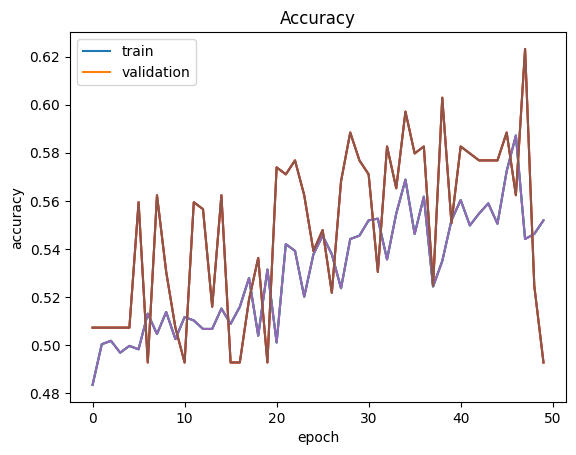

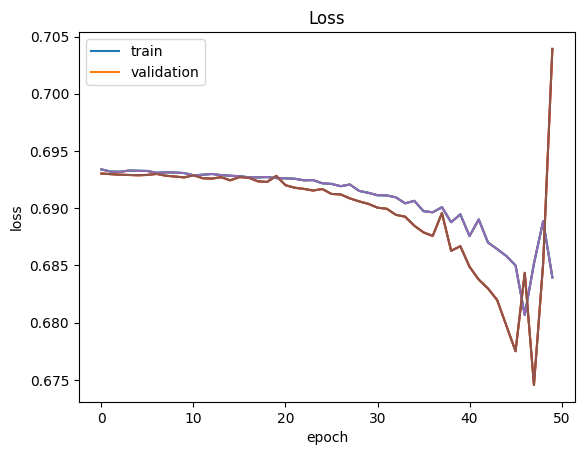

In [9]:
# Accuracy graph
plt.figure(1)
plt.plot(train.history['acc'])
plt.plot(train.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('VGG16_Accuracy_1.png')
print("Saved Accuracy graph")

# Loss graph
plt.figure(2)
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('VGG16_Loss_1.png')
print("Saved Loss graph")

plt.show()